In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os

def load_sparse_matrix(filename):
    """Load a sparse matrix from an NPZ file."""
    matrix_data = np.load(filename)
    data = matrix_data['matrix_data']
    indices = matrix_data['matrix_indices']
    indptr = matrix_data['matrix_indptr']
    shape = tuple(matrix_data['matrix_shape'])
    
    return sp.csc_matrix((data, indices, indptr), shape=shape)

def visualize_matrices(matrix_files, output_file=None):
    """Visualize multiple sparse matrices side by side."""
    num_matrices = len(matrix_files)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5*num_matrices, 5))
    
    if num_matrices == 1:
        axes = [axes]
    
    for i, (file_path, ax) in enumerate(zip(matrix_files, axes)):
        # Extract stride value from filename
        stride = int(os.path.basename(file_path).split('_stride_')[1].split('.')[0])
        sparsity = int(os.path.basename(file_path).split('_sparsity_')[1].split('_')[0])
        
        # Load the matrix
        sparse_matrix = load_sparse_matrix(file_path)
        
        # Convert to dense for visualization (only for small matrices)
        if sparse_matrix.shape[0] <= 100:  # Only convert if it's not too large
            dense_matrix = sparse_matrix.toarray()
            
            # Display the matrix
            cax = ax.imshow(dense_matrix != 0, cmap='Blues', interpolation='none')
            ax.set_title(f'Stride = {stride}\nSparsity = {sparsity}%')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            
            # Add sparsity information
            nonzeros = sparse_matrix.count_nonzero()
            total = sparse_matrix.shape[0] * sparse_matrix.shape[1]
            actual_sparsity = 100 * (1 - nonzeros/total)
            ax.text(0.5, -0.15, 
                   f'Non-zeros: {nonzeros}\nActual sparsity: {actual_sparsity:.1f}%',
                   transform=ax.transAxes, ha='center')
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

def analyze_matrix_patterns(matrix_files):
    """Analyze and print statistics about the matrices."""
    results = []
    
    for file_path in matrix_files:
        # Extract info from filename
        stride = int(os.path.basename(file_path).split('_stride_')[1].split('.')[0])
        target_sparsity = int(os.path.basename(file_path).split('_sparsity_')[1].split('_')[0])
        
        # Load the matrix
        sparse_matrix = load_sparse_matrix(file_path)
        
        # Calculate actual statistics
        nonzeros = sparse_matrix.count_nonzero()
        total = sparse_matrix.shape[0] * sparse_matrix.shape[1]
        actual_sparsity = 100 * (1 - nonzeros/total)
        
        # Calculate distribution metrics
        if sparse_matrix.shape[0] <= 100:  # Only analyze pattern for reasonably sized matrices
            dense = sparse_matrix.toarray() != 0
            
            # Check for pattern regularity based on stride
            regularity = np.sum(dense[::stride, ::stride]) / np.sum(dense)
            
            results.append({
                'file': os.path.basename(file_path),
                'stride': stride,
                'target_sparsity': target_sparsity,
                'actual_sparsity': actual_sparsity,
                'nonzeros': nonzeros,
                'pattern_regularity': regularity
            })
    
    # Print results
    print("\nMatrix Analysis Results:")
    print("-" * 80)
    print(f"{'Filename':<30} {'Stride':<8} {'Target %':<10} {'Actual %':<10} {'Non-zeros':<12} {'Regularity %':<12}")
    print("-" * 80)
    
    for r in results:
        print(f"{r['file']:<30} {r['stride']:<8} {r['target_sparsity']:<10.1f} {r['actual_sparsity']:<10.1f} {r['nonzeros']:<12} {r['pattern_regularity']*100:<12.2f}")
    
    return results

# For Jupyter notebook usage
def visualize_sparse_matrices(matrix_dir="../matrices_2", sparsity=80, output_file=None):
    """
    Visualize sparse matrices with different strides but same sparsity.
    
    Parameters:
    -----------
    matrix_dir : str
        Directory containing the matrix files
    sparsity : int
        Sparsity level to compare (default: 80)
    output_file : str or None
        Output file for visualization (optional)
    """
    # Find matrix files with the specified sparsity and different strides
    matrix_files = []
    for stride in [1, 2, 3, 4]:
        pattern = f"matrix_sparsity_{sparsity}_stride_{stride}.npz"
        file_path = os.path.join(matrix_dir, pattern)
        if os.path.exists(file_path):
            matrix_files.append(file_path)
        else:
            print(f"Warning: File not found: {file_path}")
    
    if not matrix_files:
        print(f"No matrix files found with sparsity {sparsity}% in directory {matrix_dir}")
        return None, None
    
    print(f"Found {len(matrix_files)} matrices to visualize")
    
    # Visualize the matrices
    fig = visualize_matrices(matrix_files, output_file)
    
    # Analyze patterns
    results = analyze_matrix_patterns(matrix_files)
    
    return fig, results

Found 3 matrices to visualize


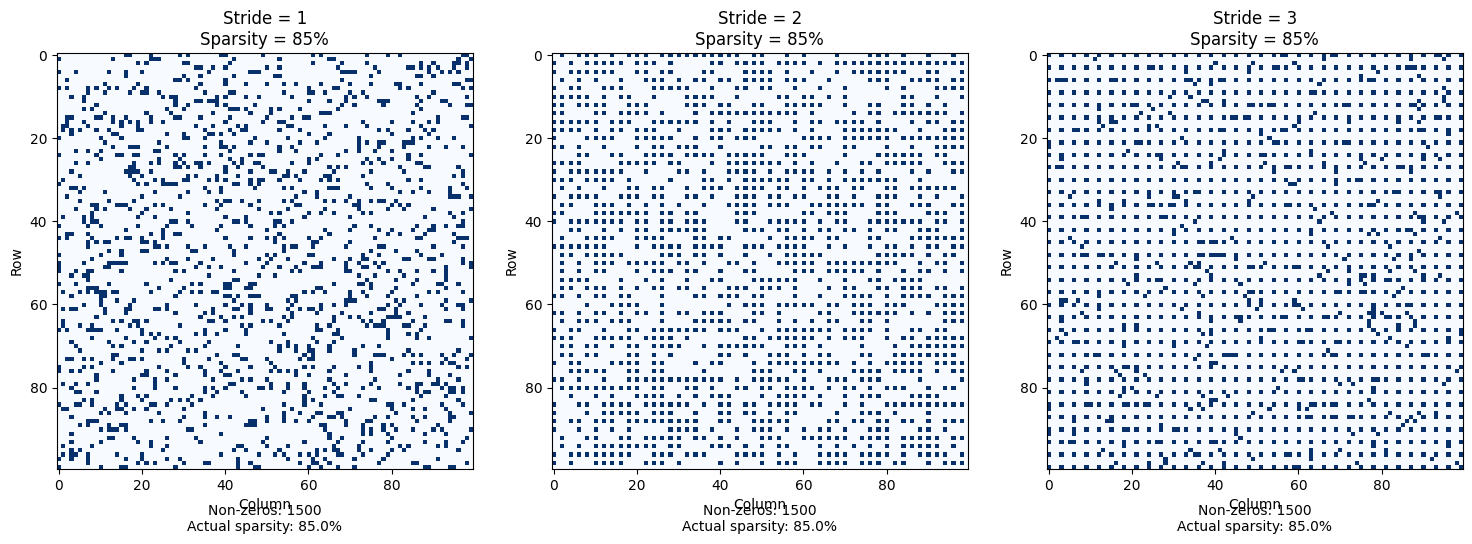


Matrix Analysis Results:
--------------------------------------------------------------------------------
Filename                       Stride   Target %   Actual %   Non-zeros    Regularity %
--------------------------------------------------------------------------------
matrix_sparsity_85_stride_1.npz 1        85.0       85.0       1500         100.00      
matrix_sparsity_85_stride_2.npz 2        85.0       85.0       1500         100.00      
matrix_sparsity_85_stride_3.npz 3        85.0       85.0       1500         77.07       


In [6]:
# First, execute the code above to define all the functions

# Then use this simplified function that doesn't require command-line arguments
fig, results = visualize_sparse_matrices(
    matrix_dir="../matrices",  # Path to your matrix files directory
    sparsity=85,               # Sparsity level to compare (80%)
    output_file='stride_comparison.png'           # Optional: provide a filename to save the figure
)

# You can also explore different sparsity levels
# For example, to visualize matrices with 70% sparsity:
# fig, results = visualize_sparse_matrices(matrix_dir="../matrices", sparsity=70)